## Utilisation du jeu de données Xview2, qui intitialement présebnte des exemples de territoire avant et après dommage

Je m'écarte ici un peu de l'idée initiale qui était de produire un dataset à l'aide du RIl et de la BDTOPO et je me concentre + sur les datasets labellisés préexistants. J'entraine un modèle de segmentation de suus ou un modèle de déttection d'objet et je vois comment ça réagit sur donnée spleiades. 
Dans tousd les cas le travail sur le RIL et la BD TOPO est à conserver puisque ces derniers servent de vzlidation !

In [2]:
from zipfile import ZipFile
import s3fs
import tarfile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+'minio.lab.sspcloud.fr'},key ='HPC7PNZMF3SC28Q5FYY3', secret = '3DfluFzC0ZqQlCk2ifJLNy4Xra0D4tbwzoraa2ET', token = 'eyJhbGciOiJIUzUxMiIsInR5cCI6IkpXVCJ9.eyJhY2Nlc3NLZXkiOiJIUEM3UE5aTUYzU0MyOFE1RllZMyIsImFsbG93ZWQtb3JpZ2lucyI6WyIqIl0sImF1ZCI6WyJtaW5pby1kYXRhbm9kZSIsIm9ueXhpYSIsImFjY291bnQiXSwiYXV0aF90aW1lIjoxNjc1MzM4MzkyLCJhenAiOiJvbnl4aWEiLCJlbWFpbCI6ImNsZW1lbnQuZ3VpbGxvQGluc2VlLmZyIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImV4cCI6MTY3NTQ0ODc5MSwiZmFtaWx5X25hbWUiOiJHdWlsbG8iLCJnaXZlbl9uYW1lIjoiQ2zDqW1lbnQiLCJncm91cHMiOlsiY2hhbGxlbmdlZGF0YS1lbnMiLCJmdW5hdGhvbiIsInNsdW1zLWRldGVjdGlvbiJdLCJpYXQiOjE2NzUzMzk2NTIsImlzcyI6Imh0dHBzOi8vYXV0aC5sYWIuc3NwY2xvdWQuZnIvYXV0aC9yZWFsbXMvc3NwY2xvdWQiLCJqdGkiOiI2NWVhMDA1Zi1hOTg0LTQ1ODctYWRhMS01ZWI5MTI4Mzg5NDMiLCJsb2NhbGUiOiJlbiIsIm5hbWUiOiJDbMOpbWVudCBHdWlsbG8iLCJub25jZSI6ImUwNDY0Zjc3LTU0OTctNGVmMi04NGRkLTI1OTdhNGIwNzI5OSIsInBvbGljeSI6InN0c29ubHkiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJjZ3VpbGxvIiwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGdyb3VwcyBlbWFpbCIsInNlc3Npb25Qb2xpY3kiOiJleUpXWlhKemFXOXVJam9pTWpBeE1pMHhNQzB4TnlJc0lsTjBZWFJsYldWdWRDSTZXM3NpUldabVpXTjBJam9pUVd4c2IzY2lMQ0pCWTNScGIyNGlPbHNpY3pNNktpSmRMQ0pTWlhOdmRYSmpaU0k2V3lKaGNtNDZZWGR6T25Nek9qbzZjSEp2YW1WMExYTnNkVzF6TFdSbGRHVmpkR2x2YmlJc0ltRnlianBoZDNNNmN6TTZPanB3Y205cVpYUXRjMngxYlhNdFpHVjBaV04wYVc5dUx5b2lYWDBzZXlKRlptWmxZM1FpT2lKQmJHeHZkeUlzSWtGamRHbHZiaUk2V3lKek16cE1hWE4wUW5WamEyVjBJbDBzSWxKbGMyOTFjbU5sSWpwYkltRnlianBoZDNNNmN6TTZPam9xSWwwc0lrTnZibVJwZEdsdmJpSTZleUpUZEhKcGJtZE1hV3RsSWpwN0luTXpPbkJ5WldacGVDSTZJbVJwWm1aMWMybHZiaThxSW4xOWZTeDdJa1ZtWm1WamRDSTZJa0ZzYkc5M0lpd2lRV04wYVc5dUlqcGJJbk16T2tkbGRFOWlhbVZqZENKZExDSlNaWE52ZFhKalpTSTZXeUpoY200NllYZHpPbk16T2pvNktpOWthV1ptZFhOcGIyNHZLaUpkZlYxOSIsInNlc3Npb25fc3RhdGUiOiI3YzFjMWIzNi0xNDM4LTQ2OWItOWYwNi1lOGY1ODFkMWM4MzkiLCJzaWQiOiI3YzFjMWIzNi0xNDM4LTQ2OWItOWYwNi1lOGY1ODFkMWM4MzkiLCJzdWIiOiIzYjA2ZWZhNC01OWZlLTQzYzgtYTAyYi1hOTRkOWI0YjU0NGUiLCJ0eXAiOiJCZWFyZXIifQ.ob4PwOHQerwgrx_es8u_nIHph-Iqt_1RLz4CvR_Bn8D67q8XJoGsHULDKvV19i6dB9TPZA-qi2oYIzVGOD3SJA')

In [3]:
# je travaille sur une version minimale du dataset xview, le vrai fait 50 giga.. mais ça devrait déjà faire l'affaire pour travailler
fs.get('projet-slums-detection/Donnees/data_xBD.tar', 'data_xBD.tar')

In [4]:
tar = tarfile.open("data_xBD.tar", "r:gz")
tar.extractall()
tar.close()

### chargement/observation en place des données

In [46]:
liste_image  = sorted(os.listdir("train/images/"))
liste_label  = sorted(os.listdir("train/labels/")) # boundingbox et polygones !!
liste_target  = sorted(os.listdir("train/targets/")) # le masque de segmentation !!

5598


['guatemala-volcano_00000000_pre_disaster.png',
 'guatemala-volcano_00000001_post_disaster.png',
 'guatemala-volcano_00000001_pre_disaster.png',
 'guatemala-volcano_00000002_post_disaster.png',
 'guatemala-volcano_00000002_pre_disaster.png',
 'guatemala-volcano_00000006_post_disaster.png',
 'guatemala-volcano_00000006_pre_disaster.png',
 'guatemala-volcano_00000007_post_disaster.png',
 'guatemala-volcano_00000007_pre_disaster.png']

In [42]:
label_path = 'train/labels/hurricane-florence_00000024_pre_disaster.json'

In [68]:
selec_pre_disaster = [nom_image.split("_")[2] == "pre" for nom_image in liste_image]
liste_image = np.array(liste_image)[selec_pre_disaster]
liste_label = np.array(liste_label)[selec_pre_disaster]
liste_target = np.array(liste_target)[selec_pre_disaster]

print(np.sum(selec_pre_disaster)) # 3000 images pour s'entrainer avec des exemples entourés


2799


## Observation du dataset

- Images de dimension 1024-1024 à découper en 4 * 250 pour avoir un diviseur de 2000 (pour les données pleiades) (donc en 4)
- Dans la classe data set splitter l'image en 4 et prendre un bout aléatoirement à chaque fois
- image à 3 channels, pas de RGB ici..
- est ce vraiment la mêlme résolution que pleiade ? résistance à la résolution ?

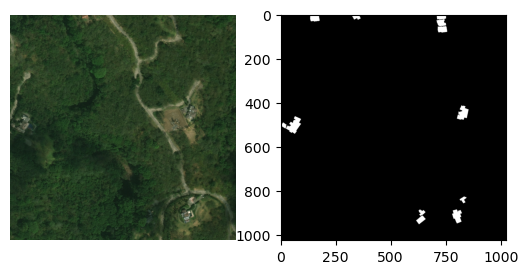

In [124]:
img = Image.open("train/images/guatemala-volcano_00000007_pre_disaster.png")
img = img.resize((1000,1000))

masque = Image.open("train/targets/guatemala-volcano_00000007_pre_disaster_target.png")
masque = np.array(masque)
show_mask = np.empty((*masque.shape, 3))
show_mask[masque == 1, :] = [255,255,255]
show_mask = show_mask.astype(np.uint8)

# On traçe
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img)
ax1.axis("off")
ax2.imshow(show_mask)
plt.show()

A mettre dans la classe dataset ! sélection d'un pa(tch aléatoire parmi les 16  possibles

1 0
(250, 750, 500, 1000)


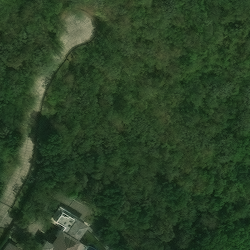

In [128]:
img = Image.open("train/images/guatemala-volcano_00000007_pre_disaster.png")

img = img.crop((0,0,1000,1000))# je dégomme les derniers pixels..
img

facteur_div = 250
width, height = img.size

num_subparts_x = width//facteur_div
num_subparts_y =  height//facteur_div

# sélection aléatoire d'une aprtie de l'image pour le dataset
i = np.random.randint(num_subparts_x)
j = np.random.randint(num_subparts_y)

print(i,j)
print((left,top,right,bottom))

left = j * facteur_div
right = (j+1) * facteur_div
top = i * facteur_div
bottom =(i+1)*facteur_div

img.crop((left,top,right,bottom))


Polygones associés au bati

In [20]:
import json
f = open(label_path)
dico = json.load(f)
  
# Closing file
f.close()

In [21]:
dico.keys()
dico["metadata"]

{'sensor': 'GEOEYE01',
 'provider_asset_type': 'GEOEYE01',
 'gsd': 1.958603,
 'capture_date': '2018-04-06T15:49:36.000Z',
 'off_nadir_angle': 24.974987,
 'pan_resolution': 0.4894778,
 'sun_azimuth': 140.36385,
 'sun_elevation': 55.891373,
 'target_azimuth': 282.33646,
 'disaster': 'hurricane-florence',
 'disaster_type': 'flooding',
 'catalog_id': '105001000F48CD00',
 'original_width': 1024,
 'original_height': 1024,
 'width': 1024,
 'height': 1024,
 'id': 'MjM1NDMxMg.nXO3IBd7BnYBtW8COFwnVkMrXUQ',
 'img_name': 'hurricane-florence_00000024_pre_disaster.png'}

## Classe Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths,target_paths,label_paths):   # initial logic happens like transform
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        with TiffFile(self.mask_paths[idx]) as tif :
            mask = tif.asarray()
        
        with TiffFile(self.image_paths[idx]) as tif :
            image = np.array(tif.asarray())
     
        t_mask = torch.tensor(mask,dtype = torch.long)
        image = torch.tensor(np.array(image,dtype = float), dtype =torch.float)
        
        ID = str(self.mask_paths[idx])
        return {"image": image, "masque" : t_mask, "id" : ID} 
        
        
    def __len__(self):  
        return len(self.mask_paths)
    